In [1]:
%gui qt

import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
from skimage.exposure import rescale_intensity
from scipy.ndimage.measurements import center_of_mass
import imageio

import utoolbox.utils.files as fileutils
from utoolbox.container import Image

### Step 0
Parameters

In [2]:
# number of bins
n_bins = 24

### Step 1
Preset environment.

In [3]:
# global progressbar utility
bar = progressbar.ProgressBar()

Grids

In [4]:
bins = np.linspace(-np.pi, np.pi, n_bins+1, dtype=np.float)
polar_grid = np.linspace(-np.pi, np.pi, n_bins, endpoint=False)

Create plots for preview image.

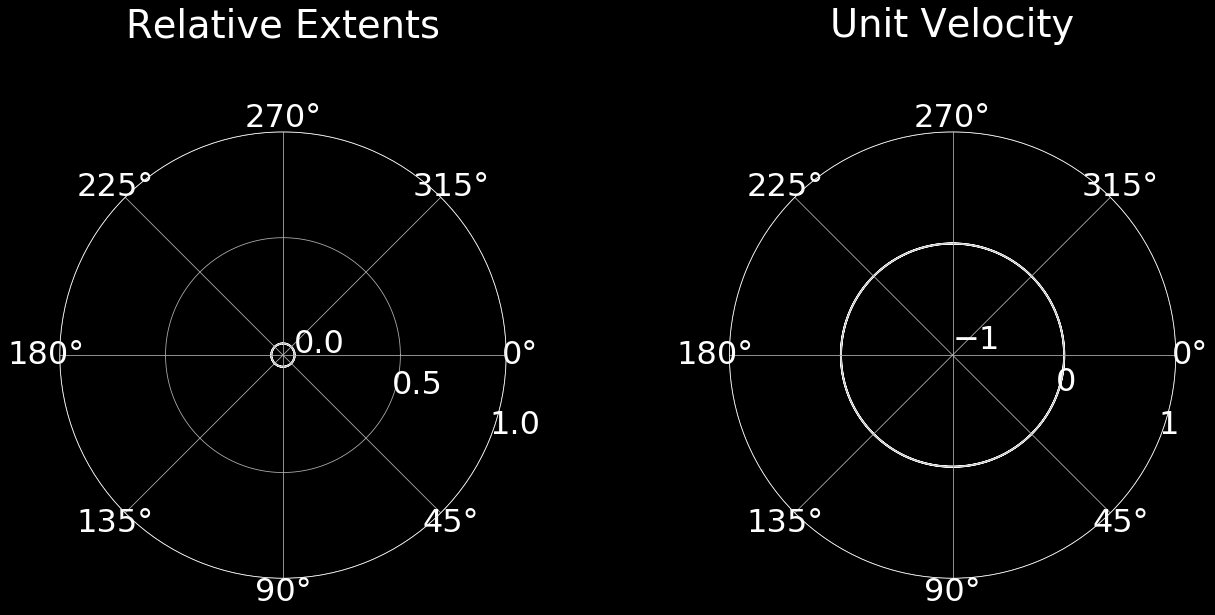

In [7]:
plt.rcParams['font.size'] = 32
plt.rcParams['text.color'] = 'w'
plt.rcParams['axes.facecolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['figure.facecolor'] = 'k'
plt.rcParams['savefig.facecolor'] = 'k'
plt.rcParams['savefig.edgecolor'] = 'k'

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.5)
ax_d = fig.add_subplot(1, 2, 1, projection='polar')
ax_d.set_title('Relative Extents', y=1.2)
ax_d.set_theta_direction(-1)
ax_d.set_theta_zero_location('E')
#bar_d = ax_d.bar(polar_grid, np.zeros_like(polar_grid), width=2*np.pi/n_bins, color='lightblue', edgecolor='k')
bar_d = ax_d.bar(polar_grid, np.zeros_like(polar_grid), width=2*np.pi/n_bins, color=(1., 1., 1., 0.25), edgecolor='w', fill=True, linewidth=2)
ax_d.set_yticks([0, 0.5, 1])

ax_v = fig.add_subplot(1, 2, 2, projection='polar')
ax_v.set_title('Unit Velocity', y=1.2)
ax_v.set_theta_direction(-1)
ax_v.set_theta_zero_location('E')
#bar_v = ax_v.bar(polar_grid, np.zeros_like(polar_grid), width=2*np.pi/n_bins, color='lightblue', edgecolor='k')
bar_v = ax_v.bar(polar_grid, np.zeros_like(polar_grid), width=2*np.pi/n_bins, color=(1., 1., 1., 0.25), edgecolor='w', fill=True, linewidth=2)
ax_v.set_yticks([-1, 0, 1])

### Step 2
List files.

In [ ]:
source_folder = fileutils.get_local_directory()
print(source_folder)
file_list = fileutils.list_files(
    source_folder, 
    name_filters=[fileutils.ExtensionFilter('tif')]
)

### Step 3
Generate output folder.

In [ ]:
parent_dir = os.path.dirname(source_folder)
direction_dir = os.path.join(parent_dir, 'direction_preview')
if not os.path.exists(direction_dir):
    os.makedirs(direction_dir)

### Step 4
Iterate over the contours for directionality analysis.

In [ ]:
def contour_to_extents(contour):
    # convert to index
    contour = np.where(contour == True)
    x = contour[1].astype(np.float)
    y = contour[0].astype(np.float)
    cx = np.mean(x)
    cy = np.mean(y)
    
    # convert to polar coordinate system
    x -= cx
    y -= cy
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    # cardinal direction
    cardinal = np.digitize(theta, bins) - 1
    
    # directional distance, maximum
    distance = np.zeros(n_bins, dtype=np.float)
    for c, r in zip(cardinal, radius):
        distance[c] = max(distance[c], r)
    
    return distance

In [ ]:
def variations(curr_dist, prev_dist):
    if prev_dist is None:
        return np.zeros_like(curr_dist)
    
    velocity = curr_dist - prev_dist
    
    return velocity

In [ ]:
prev_dist = None
cardinal_map = {}
frame = 0
for file_path in bar(file_list):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        contour = Image(file_path)
    contour = rescale_intensity(contour, out_range=(0., 1.))
    
    # update distance list
    curr_dist = contour_to_extents(contour)
    
    # update velocity list
    velocity = variations(curr_dist, prev_dist)
    prev_dist = curr_dist
    
    cardinal_map[frame] = pd.DataFrame({
        'distance': curr_dist,
        'velocity': velocity
    })
    frame += 1

# convert to DataFrame
cardinal_map = pd.concat(cardinal_map.values(), axis=0, keys=cardinal_map.keys())

Get baseline.

In [ ]:
mean_d = cardinal_map['distance'].max()
mean_v = cardinal_map['velocity'].max()

Calculate relative intensity.

In [ ]:
cardinal_map['rel_distance'] = cardinal_map['distance'] / mean_d
cardinal_map['rel_velocity'] = cardinal_map['velocity'] / mean_d

Save result as CSV.

In [ ]:
cardinal_map.to_csv(os.path.join(direction_dir, 'summary.csv'))

Generate previews.

In [ ]:
bar = progressbar.ProgressBar()
frame = 0
for file_path in bar(file_list):
    file_name = os.path.basename(file_path)
    
    for obj, height in zip(bar_d, cardinal_map.loc[frame, 'rel_distance']):
        obj.set_height(height)
    for obj, height in zip(bar_v, cardinal_map.loc[frame, 'rel_velocity']):
        obj.set_height(height)
    fig.canvas.draw()
    
    # save the preview
    fig.savefig(os.path.join(direction_dir, file_name))
    
    frame += 1